# PWL - Lattice

In [ ]:
# %load PWLLattice.py

In [2]:
# %load PWLLattice.py
# PWL - Lattice numpy Version
# PWL - Lattice model is an 1-input model

# Query Phase:
## calculate_query_cardinality_numpy

# Generation Phase:
## generate_from_batches / np.concatenate

# no Plottings
import warnings

warnings.filterwarnings("ignore")
import argparse
import itertools
import os
import sys

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_lattice as tfl
from matplotlib import pyplot as plt
from tqdm import tqdm

from models import *
from query_func import *

parser = argparse.ArgumentParser()
parser.add_argument("--dataset", type=str, default="wine2", help="Dataset.")
parser.add_argument("--query-size", type=int, default=1000, help="query size")
parser.add_argument("--min-conditions", type=int, default=1, help="min num of conditions")
parser.add_argument("--max-conditions", type=int, default=2, help="max num of conditions")
parser.add_argument("--epochs", type=int, default=100, help="Number of epochs to train for.")
parser.add_argument("--bs", type=int, default=10000, help="Batch size.")
parser.add_argument("--loss", type=str, default="MSE", help="Loss.")
parser.add_argument("--lattice-size", type=int, default=2, help="Lattice size.")
parser.add_argument("--lr", type=float, default=1e-3, help="learning rate")
parser.add_argument("--seed", type=int, default=42, help="Random seed")

try:
    args = parser.parse_args()
except:
    # args = parser.parse_args([])
    args, unknown = parser.parse_known_args()


def make_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


OPS = {">": np.greater, "<": np.less, ">=": np.greater_equal, "<=": np.less_equal, "=": np.equal}

FilePath = (
    f"{args.dataset}_{args.query_size}_{args.min_conditions}_{args.max_conditions}_{args.loss}"
)
resultsPath = f"results/{FilePath}"
modelPath = f"saved_models/{FilePath}"
make_directory(resultsPath)
make_directory(modelPath)

print("\nBegin Loading Data ...")
print(f"{args.dataset}.csv")
table = np.loadtxt(f"datasets/{args.dataset}.csv", delimiter=",")
np.savetxt(f"{resultsPath}/original_table.csv", table, delimiter=",")
print("Done.\n")

print("Begin Generating Queries Set ...")
table_size = table.shape
rng = np.random.RandomState(args.seed)
query_set = [
    generate_random_query(table, args.min_conditions, args.max_conditions + 1, rng)
    for _ in tqdm(range(args.query_size))
]
print("Done.\n")

print("Begin Intervalization ...")
unique_intervals = column_intervalization(table_size, query_set)
unique_intervals
column_interval_number = count_column_unique_interval(unique_intervals)
print(f"{column_interval_number=}")
print("Done.\n")

# 修改 x = [sys.maxsize] * n_column     # 这里使用每个col_unique_interval的最后一个元素即可
# 如果使用两个input的话，一个修改为最大，一个修改为最小
train_X = []
n_column = table_size[1]
for query in query_set:
    x = [sys.maxsize] * n_column  # 这里使用每个col_unique_interval的最后一个元素即可
    idxs, _, vals, _ = query
    for i in range(len(idxs)):
        x[idxs[i]] = vals[i]
    train_X.append(x)
train_X = np.array(train_X).astype(np.float32)
train_Y = np.array([[query[-1]] for query in query_set], dtype=np.float32)


# PWL改成三次样条
m = PWLLattice(
    modelPath,
    table_size,
    unique_intervals,
    pwl_keypoints=None,
    lattice_size=args.lattice_size,
)

m.fit(train_X, train_Y, lr=args.lr, bs=args.bs, epochs=args.epochs, loss=args.loss)
m.load()

dataNew = m.generate(unique_intervals, batch_size=10000)
np.savetxt(f"{resultsPath}/generated_table.csv", dataNew, delimiter=",")

Q_error = calculate_Q_error(dataNew, query_set, table_size)
print_Q_error(Q_error, args, resultsPath)

In [11]:
dataNew.shape, table_size

((6375, 2), (6497, 2))

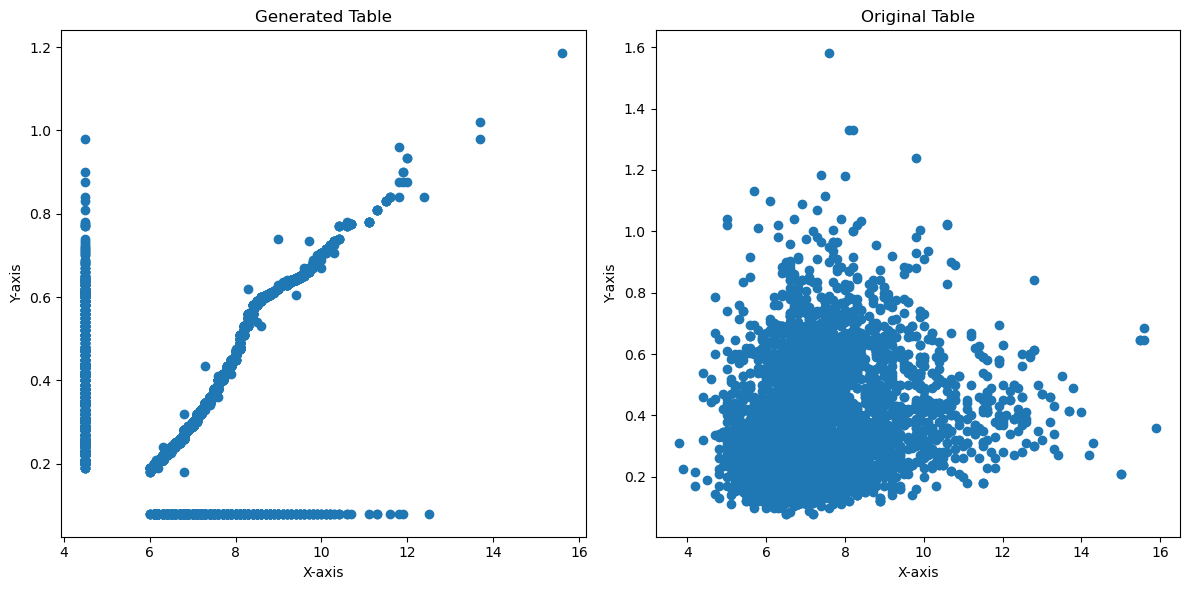

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(dataNew[:, 0], dataNew[:, 1], "o")
axs[0].set_title("Generated Table")
axs[0].set_xlabel("X-axis")
axs[0].set_ylabel("Y-axis")

axs[1].plot(table[:, 0], table[:, 1], "o")
axs[1].set_title("Original Table")
axs[1].set_xlabel("X-axis")
axs[1].set_ylabel("Y-axis")
plt.tight_layout()
plt.show()

In [13]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### 测试简单分布中，使用generate是否能得到正确的分布

In [ ]:
data = np.array([[2, 9], [5, 4], [3, 1], [9, 3], [2, 9], [2, 9], [3, 10], [9, 1], [10, 1], [10, 1]])
values = [range(1, 11), range(1, 11)]
mesh = np.meshgrid(*values)  # 所有unique interval 的笛卡尔积网格
grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)
results = []
df = pd.DataFrame(data, columns=["x", "y"])
for x in range(1, 11):
    for y in range(1, 11):
        count = df[(df["x"] <= x) & (df["y"] <= y)].shape[0]
        results.append(count)
pred = np.array(results).reshape(-1, 1) / df.shape[0]

In [ ]:
n_row = df.shape[0]
n_column = df.shape[1]

In [ ]:
def generate_5(grid, pred=None):
    # numpy / calculate_query_cardinality_numpy / np.concatenate
    # generate by row, one query may generate several rows
    print("Begin Generating Table ...")
    count = 0
    ArrayNew = None
    ops = ["<="] * n_column
    pred = (pred * n_row).astype(int)  # Case 1: change 0.8 to 0, 1.8 to 1
    for i in tqdm(range(grid.shape[0])):
        vals = grid[i]
        card = pred[i, 0] - calculate_query_cardinality(ArrayNew, ops, vals)
        if card >= 1:
            array3 = np.repeat(vals, card).reshape(self.n_column, card).T
            ArrayNew = array3 if ArrayNew is None else np.concatenate((ArrayNew, array3), axis=0)
            count += card
            if count > n_row:
                print(
                    f"Reached table max row length({n_row}) in {i}-th row of grid with grid value of {vals}, stop generation."
                )
                break
    else:
        print("Done.\n")
        # if count < n_row:
        #     print(
        #         f"Generated table row length({count}) is less than the original table row length({n_row})."
        #     )
        #     # 如果不足,补系统最大值吗？
        return ArrayNew
    return ArrayNew[:n_row, :]

In [ ]:
dataNew = generate_5(grid, pred)
dataNew

In [ ]:
dataNew.plot(kind="scatter", x="col_0", y="col_1", alpha=0.5)

### 做不做 unique Train set 有什么区别？

#### 为什么 kl散度是负数，修改 epoch为一个很小的值，看看是否会出现负数

In [ ]:
# 可能与网络的初始化输出值有关？
# 使用 kl散度是否时正确的，如何使用神经网络进行最大似然估计，似然与kl散度之间的关系是什么？

In [ ]:
grid_pred

In [ ]:
train_X

In [ ]:
train_X.shape

In [ ]:
train_Y.shape

In [ ]:
m.predict(train_X)

# 画图

In [ ]:
# 把plot 整合到 lattice里，或者单独写几个函数

In [ ]:
grid_pred = m.predict(grid)

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(grid_pred, "bo")

In [ ]:
fig1 = plt.figure(figsize=(15, 8))
ax1 = plt.axes(projection="3d")

# xx = unique_intervals[1]
# yy = unique_intervals[0]
# X, Y = np.meshgrid(xx, yy)

X = grid[:, 1].reshape(column_interval_number[0], column_interval_number[1])  # 这样也可以
Y = grid[:, 0].reshape(column_interval_number[0], column_interval_number[1])
Z = grid_pred.reshape(column_interval_number[0], column_interval_number[1])

ax1.plot_surface(X, Y, Z, cmap="viridis")
plt.show()

In [ ]:
fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(111)
cs = ax2.contourf(X, Y, Z, cmap="viridis")

# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())    # 这个是啥

cbar = fig2.colorbar(cs)  # 让colorbar细粒度更高一点
plt.show()

In [ ]:
# 画一下原生的图做对比，是否需要更光滑
# 变得光滑：
# 1. 数据预处理，缩放，标准化
# 2. 凸函数
# 3. lattice正则器

In [ ]:
# query 对网格的覆盖率 散点图
fig4 = plt.figure(figsize=(10, 10))
xtick = unique_intervals[0]
ytick = unique_intervals[1]
plt.scatter(train_X[:, 0], train_X[:, 1], c="b")
plt.vlines(xtick, min(ytick), max(ytick), colors="green")
plt.hlines(ytick, min(xtick), max(xtick), colors="green")
plt.show()

# Lattice 其它尝试

In [ ]:
# 对比，对query做unique 和 不做unique的误差

In [ ]:
# 对比传入table unique value 和 只传入 unique_intervals的模型优化效果

In [ ]:
# table unique value
data = table.data.to_numpy()
unique_vals = []
for i in range(data.shape[1]):
    unique_vals.append(np.unique(data[:, i]))

In [ ]:
unique_vals